In [1]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

We are giving you a 2 layer transformer model in induction task. Check the data generation mechanism for the induction head and adjust it accordingly to your needs. For AR, you need to code one from scratch. 

In [2]:
class InductionAR(Dataset):
    # In induction head we have ngram = 1. But the code provided is for general ngram setting. While using this, initialize ngram = 1. 
    """ Naive associative recall dataset """
    def __init__(self, num_examples, tokenizer, n_gram=1, n_ctx = 1024, seed = 0, train_split=0.8, tau=1):
        self.num_examples = num_examples
        self.tokenizer = tokenizer
        self.n_ctx = n_ctx
        self.seed = seed
        self.n_gram = n_gram
        self.tau = tau
        x, y = self.data_gen()
        if train_split:
            self.train_x, self.train_y, self.test_x, self.test_y = self.split(x, y, train_split)
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = self.numpy_to_tensor_dataset(self.test_x, self.test_y)
        else:
            self.train_x, self.train_y, self.test_x, self.test_y = x, y, None, None
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = None
    def get_str_dataset(self, split="train"):
        if split == "train":
            x_str = [self.tokenizer.decode(xi) for xi in self.train_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.train_y]
        elif split == "test":
            x_str = [self.tokenizer.decode(xi) for xi in self.test_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.test_y]
        else:
            raise ValueError("split should be either 'train' or 'test'")
        return x_str, y_str
    def numpy_to_tensor_dataset(self, x, y):
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return TensorDataset(x, y)
    def gen_single_example(self):
        # get the vocab size
        def count(str_x, str_n_gram_head):
            counts = sum([
                str_x.startswith(str_n_gram_head, i) for i in range(len(str_x))
            ])
            return counts
        def gen_x():
            gen_x_success = False
            while not gen_x_success:
                x = np.random.choice(vocab, self.n_ctx-self.n_gram*2, replace=True).tolist()
                # remove the case where the n_gram_head is repeated in the sequence
                for _ in range(10):
                    pos = [i for i in range(len(x)-len(n_gram_head)+1) if x[i:i+len(n_gram_head)] == n_gram_head]
                    if len(pos) == 0:
                        gen_x_success = True
                        break
                    else:
                        # remove the n_gram_head from x
                        # get all positions of the n_gram_head in x
                        for p in reversed(pos):
                            # remove len(n_gram_head) elements from x starting from p
                            x = x[:p] + x[p+len(n_gram_head):]
                        # fill the rest of the sequence with random elements
                        x.extend(np.random.choice(vocab, self.n_ctx-self.n_gram*2-len(x), replace=True).tolist())
                x_test = " ".join([str(xi) for xi in x])
                if count(x_test, str_n_gram_head) == 0:
                    gen_x_success = True

            x_test = x + n_gram_head
            # check if there's only one n_gram_head in the sequence
            # to avoid the case where the n_gram_head has 
            # repeated structure such as x= [1, 2, 3, 1] , n_gram_head = [1, 1]
            str_x_test = " "+" ".join([str(xi) for xi in x_test])+ " "
            if count(str_x_test, str_n_gram_head) > 1:
                print("Error in gen_x")
                print(f"str_x_test: {str_x_test}", f"str_n_gram_head: {str_n_gram_head}", 
                      "count: ", count(str_x_test, str_n_gram_head))
            if count(str_x_test, str_n_gram_head) == 1:
                return x
            else:
                return None
        # change this for tau delay
        def insert_n_gram_head(x):
            pos = random.randint(0, len(x)-self.tau)
            y = x[pos]
#             x_new = x[:pos] + n_gram_head + x[pos:] + n_gram_head
            x_new = x[:pos-self.tau+1] + n_gram_head + x[pos-self.tau+1:] + n_gram_head
            str_x_new = " "+" ".join([str(xi) for xi in x_new])+" "

            if count(str_x_new, str_n_gram_head) == 2:
                return x_new, y
            else:
                return None, None

        vocab_size = len(self.tokenizer)
        vocab = list(range(vocab_size))
        
        # set a random n_gram_head for AR task
        n_gram_heads = list(range(self.n_gram))
        n_gram_head = [random.choice(n_gram_heads)]
       
        str_n_gram_head = " "+" ".join([str(xi) for xi in n_gram_head])+" "
        assert self.n_gram*2 < self.n_ctx, "n_gram*2 should be less than n_ctx"
        success = False
        while not success:
            x = gen_x()
            if x is not None:
                for _ in range(10):
                    x_new, y = insert_n_gram_head(x)
                    if x_new is not None:
                        success = True
                        break
        return x_new, y
            
    def data_gen(self):
        x = []
        y = []
        # get previous random status and recover after generating the dataset
        random_status = random.getstate()
        random.seed(self.seed)
        for i in range(self.num_examples):
            if i % 5000 == 0:
                print(f"Generating example {i}")
            xi, yi = self.gen_single_example()
            x.append(xi)
            y.append(yi)
        x = np.array(x)
        y = np.array(y)
        random.setstate(random_status)
        return x, y
    def split(self, x, y, train_ratio = 0.8):
        num_train = int(len(x)*train_ratio)
        train_x = x[:num_train]
        train_y = y[:num_train]
        test_x = x[num_train:]
        test_y = y[num_train:]
        return train_x, train_y, test_x, test_y


In [3]:
class Random_tokenizer:
    def __init__(self, vocab=None, vocab_size = None) -> None:
        """ The init function of the tokenizer class.
         one of vocab or vocab_size should be provided.
         If vocab is provided, vocab_size will be ignored.
         If vocab is not provided, vocab_size should be provided. we will generate a random vocab of vocab_size."""
        if vocab is not None:
            self.vocab = vocab
            self.vocab_size = len(vocab)
        elif vocab_size is not None:
            self.vocab_size = vocab_size
            self.vocab = [str(i) for i in range(vocab_size)]
        else:
            raise ValueError("one of vocab or vocab_size should be provided.")
        self.vocab_dict = {v: i for i, v in enumerate(self.vocab)}
        self.vocab_dict_inv = {i: v for i, v in enumerate(self.vocab)}
    def encode(self, x):
        """ Encode a string into a list of integers """
        return [self.vocab_dict[i] for i in x]
    def decode(self, x):
        """ Decode a list of integers into a string """
        return ' '.join([self.vocab_dict_inv[i] for i in x])
    def __len__(self):
        return self.vocab_size
    def __getitem__(self, i):
        return self.vocab[i]
    def __iter__(self):
        return iter(self.vocab)
    def __contains__(self, x):
        return x in self.vocab
    def __repr__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __str__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __call__(self, x):
        return self.encode(x)
        

In [4]:
# Rotary Positional Embedding
# Taken from https://github.com/facebookresearch/xformers/blob/main/xformers/components/positional_embedding/rotary.py


# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.
#
# This source code is licensed under the BSD license found in the
# LICENSE file in the root directory of this source tree.


# CREDITS: This implementation is inspired by GPT-NeoX https://github.com/EleutherAI/gpt-neox
# NOTE: Almost the same right now, moving parts to Triton is the next step

from typing import Tuple


def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)


@torch.jit.script
def apply_rotary_pos_emb(x, cos, sin):
    # NOTE: This could probably be moved to Triton

    # Handle a possible sequence length mismatch in between q and k
    cos = cos[:, :, : x.shape[-2], :]
    sin = sin[:, :, : x.shape[-2], :]

    return (x * cos) + (rotate_half(x) * sin)


class RotaryEmbedding(torch.nn.Module):
    """
    The rotary position embeddings from RoFormer_ (Su et. al).
    A crucial insight from the method is that the query and keys are
    transformed by rotation matrices which depend on the relative positions.

    Other implementations are available in the Rotary Transformer repo_ and in
    GPT-NeoX_, GPT-NeoX was an inspiration

    .. _RoFormer: https://arxiv.org/abs/2104.09864
    .. _repo: https://github.com/ZhuiyiTechnology/roformer
    .. _GPT-NeoX: https://github.com/EleutherAI/gpt-neox


    .. warning: Please note that this embedding is not registered on purpose, as it is transformative
        (it does not create the embedding dimension) and will likely be picked up (imported) on a ad-hoc basis
    """

    def __init__(self, dim_model: int, *_, **__):
        super().__init__()
        # Generate and save the inverse frequency buffer (non trainable)
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim_model, 2).float() / dim_model))
        self.register_buffer("inv_freq", inv_freq)

        self._seq_len_cached = None
        self._cos_cached = None
        self._sin_cached = None

    def _update_cos_sin_tables(self, x, seq_dimension=1):
        seq_len = x.shape[seq_dimension]

        # Reset the tables if the sequence length has changed,
        # or if we're on a new device (possibly due to tracing for instance)
        if (
            seq_len != self._seq_len_cached
            or self._cos_cached.device != x.device
            or self._cos_cached.dtype != x.dtype
        ):
            self._seq_len_cached = seq_len
            t = torch.arange(
                x.shape[seq_dimension], device=x.device, dtype=torch.float32
            )
            freqs = torch.einsum("i,j->ij", t, self.inv_freq.to(x.dtype))
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)

            self._cos_cached = emb.cos()[None, None, :, :].to(x.dtype)
            self._sin_cached = emb.sin()[None, None, :, :].to(x.dtype)

        return self._cos_cached, self._sin_cached

    def forward(
        self, q: torch.Tensor, k: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        self._cos_cached, self._sin_cached = self._update_cos_sin_tables(
            k, seq_dimension=-2
        )

        return (
            apply_rotary_pos_emb(q, self._cos_cached, self._sin_cached),
            apply_rotary_pos_emb(k, self._cos_cached, self._sin_cached),
        )

In [5]:
# self attention block
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, max_len=11):
        super(AttentionBlock, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.c_attn = nn.Linear(embed_dim, embed_dim*3)
        self.register_buffer('mask', torch.tril(torch.ones(max_len, max_len)))
    def forward(self, x):
        T = x.size(1)
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        return y

In [6]:
# rotary positional encoding self attention block
class RotaryAttentionBlock(AttentionBlock):
    def __init__(self, embed_dim, max_len=11):
        super(RotaryAttentionBlock, self).__init__(embed_dim, max_len)
        self.rotary = RotaryEmbedding(embed_dim)

    def forward(self, x):
        T = x.size(1)
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        
        q, k = self.rotary(q, k)
        q, k = torch.squeeze(q, dim=0), torch.squeeze(k, dim=0)

        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        return y

### Mamba Block
Below, we copy the implementation of the Mamba block with parallel scan from this repository: https://github.com/alxndrTL/mamba.py/

We create a wrapper for this block as MambaBlockWrapper, holding all the other necessary configurations regarding the internals of the Mamba block. The other configurations (conv dimension, hidden state dimension, etc.) are taken directly from the linked repo.

In [7]:
import math
from dataclasses import dataclass
from typing import Union

"""
Taken from https://github.com/alxndrTL/mamba.py/blob/main/pscan.py

An implementation of the parallel scan operation in PyTorch (Blelloch version).
Please see docs/pscan.ipynb for a detailed explanation of what happens here.

"""

def npo2(len):
    """
    Returns the next power of 2 above len
    """

    return 2 ** math.ceil(math.log2(len))

def pad_npo2(X):
    """
    Pads input length dim to the next power of 2

    Args:
        X : (B, L, D, N)

    Returns:
        Y : (B, npo2(L), D, N)
    """

    len_npo2 = npo2(X.size(1))
    pad_tuple = (0, 0, 0, 0, 0, len_npo2 - X.size(1))
    return F.pad(X, pad_tuple, "constant", 0)

class PScan(torch.autograd.Function):
    @staticmethod
    def pscan(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # modifies X in place by doing a parallel scan.
        # more formally, X will be populated by these values :
        # H[t] = A[t] * H[t-1] + X[t] with H[0] = 0
        # which are computed in parallel (2*log2(T) sequential steps (ideally), instead of T sequential steps)

        # only supports L that is a power of two (mainly for a clearer code)
        
        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps-2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)
            
            Xa[:, :, :, 1].add_(Aa[:, :, :, 1].mul(Xa[:, :, :, 0]))
            Aa[:, :, :, 1].mul_(Aa[:, :, :, 0])

            Aa = Aa[:, :, :, 1]
            Xa = Xa[:, :, :, 1]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            Aa[:, :, 1].mul_(Aa[:, :, 0])

            Xa[:, :, 3].add_(Aa[:, :, 3].mul(Xa[:, :, 2] + Aa[:, :, 2].mul(Xa[:, :, 1])))
        elif Xa.size(2) == 2:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 2**(num_steps-2)-1:L:2**(num_steps-2)]
        Xa = X[:, :, 2**(num_steps-2)-1:L:2**(num_steps-2)]
        Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 1]))
        Aa[:, :, 2].mul_(Aa[:, :, 1])

        for k in range(num_steps-3, -1, -1):
            Aa = A[:, :, 2**k-1:L:2**k]
            Xa = X[:, :, 2**k-1:L:2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, 1:, 0].add_(Aa[:, :, 1:, 0].mul(Xa[:, :, :-1, 1]))
            Aa[:, :, 1:, 0].mul_(Aa[:, :, :-1, 1])

    @staticmethod
    def pscan_rev(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # the same function as above, but in reverse
        # (if you flip the input, call pscan, then flip the output, you get what this function outputs)
        # it is used in the backward pass

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps-2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)
                    
            Xa[:, :, :, 0].add_(Aa[:, :, :, 0].mul(Xa[:, :, :, 1]))
            Aa[:, :, :, 0].mul_(Aa[:, :, :, 1])

            Aa = Aa[:, :, :, 0]
            Xa = Xa[:, :, :, 0]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 3]))
            Aa[:, :, 2].mul_(Aa[:, :, 3])

            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1].add(Aa[:, :, 1].mul(Xa[:, :, 2]))))
        elif Xa.size(2) == 2:
            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 0:L:2**(num_steps-2)]
        Xa = X[:, :, 0:L:2**(num_steps-2)]
        Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 2]))
        Aa[:, :, 1].mul_(Aa[:, :, 2])

        for k in range(num_steps-3, -1, -1):
            Aa = A[:, :, 0:L:2**k]
            Xa = X[:, :, 0:L:2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :-1, 1].add_(Aa[:, :, :-1, 1].mul(Xa[:, :, 1:, 0]))
            Aa[:, :, :-1, 1].mul_(Aa[:, :, 1:, 0])

    @staticmethod
    def forward(ctx, A_in, X_in):
        """
        Applies the parallel scan operation, as defined above. Returns a new tensor.
        If you can, privilege sequence lengths that are powers of two.

        Args:
            A_in : (B, L, D, N)
            X_in : (B, L, D, N)

        Returns:
            H : (B, L, D, N)
        """

        L = X_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            A = A_in.clone()
            X = X_in.clone()
        else:
            # pad tensors (and clone btw)
            A = pad_npo2(A_in) # (B, npo2(L), D, N)
            X = pad_npo2(X_in) # (B, npo2(L), D, N)
        
        # prepare tensors
        A = A.transpose(2, 1) # (B, D, npo2(L), N)
        X = X.transpose(2, 1) # (B, D, npo2(L), N)

        # parallel scan (modifies X in-place)
        PScan.pscan(A, X)

        ctx.save_for_backward(A_in, X)
        
        # slice [:, :L] (cut if there was padding)
        return X.transpose(2, 1)[:, :L]
    
    @staticmethod
    def backward(ctx, grad_output_in):
        """
        Flows the gradient from the output to the input. Returns two new tensors.

        Args:
            ctx : A_in : (B, L, D, N), X : (B, D, L, N)
            grad_output_in : (B, L, D, N)

        Returns:
            gradA : (B, L, D, N), gradX : (B, L, D, N)
        """

        A_in, X = ctx.saved_tensors

        L = grad_output_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            grad_output = grad_output_in.clone()
            # the next padding will clone A_in
        else:
            grad_output = pad_npo2(grad_output_in) # (B, npo2(L), D, N)
            A_in = pad_npo2(A_in) # (B, npo2(L), D, N)

        # prepare tensors
        grad_output = grad_output.transpose(2, 1)
        A_in = A_in.transpose(2, 1) # (B, D, npo2(L), N)
        A = torch.nn.functional.pad(A_in[:, :, 1:], (0, 0, 0, 1)) # (B, D, npo2(L), N) shift 1 to the left (see hand derivation)

        # reverse parallel scan (modifies grad_output in-place)
        PScan.pscan_rev(A, grad_output)

        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_output[:, :, 1:])

        return Q.transpose(2, 1)[:, :L], grad_output.transpose(2, 1)[:, :L]
    
pscan = PScan.apply

In [8]:
# taken from https://github.com/alxndrTL/mamba.py/blob/main/mamba.py
@dataclass
class MambaConfig:
    d_model: int # D
#     n_layers: int
    dt_rank: Union[int, str] = 'auto'
    d_state: int = 16 # N in paper/comments
    expand_factor: int = 2 # E in paper/comments
    d_conv: int = 4

    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init: str = "random" # "random" or "constant"
    dt_scale: float = 1.0
    dt_init_floor = 1e-4

    bias: bool = False
    conv_bias: bool = True

    pscan: bool = True # use parallel scan mode or sequential mode when training

    def __post_init__(self):
        self.d_inner = self.expand_factor * self.d_model # E*D = ED in comments

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

class MambaBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        # projects block input from D to 2*ED (two branches)
        self.in_proj = nn.Linear(config.d_model, 2 * config.d_inner, bias=config.bias)

        self.conv1d = nn.Conv1d(in_channels=config.d_inner, out_channels=config.d_inner, 
                              kernel_size=config.d_conv, bias=config.conv_bias, 
                              groups=config.d_inner,
                              padding=config.d_conv - 1)
        
        # projects x to input-dependent Δ, B, C
        self.x_proj = nn.Linear(config.d_inner, config.dt_rank + 2 * config.d_state, bias=False)

        # projects Δ from dt_rank to d_inner
        self.dt_proj = nn.Linear(config.dt_rank, config.d_inner, bias=True)

        # dt initialization
        # dt weights
        dt_init_std = config.dt_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError
        
        # dt bias
        dt = torch.exp(
            torch.rand(config.d_inner) * (math.log(config.dt_max) - math.log(config.dt_min)) + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        #self.dt_proj.bias._no_reinit = True # initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        # todo : explain why removed

        # S4D real initialization
        A = torch.arange(1, config.d_state + 1, dtype=torch.float32).repeat(config.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A)) # why store A in log ? to keep A < 0 (cf -torch.exp(...)) ? for gradient stability ?
        self.D = nn.Parameter(torch.ones(config.d_inner))

        # projects block output from ED back to D
        self.out_proj = nn.Linear(config.d_inner, config.d_model, bias=config.bias)

    def forward(self, x):
        # x : (B, L, D)
        
        # y : (B, L, D)

        _, L, _ = x.shape

        xz = self.in_proj(x) # (B, L, 2*ED)
        x, z = xz.chunk(2, dim=-1) # (B, L, ED), (B, L, ED)

        # x branch
        x = x.transpose(1, 2) # (B, ED, L)
        x = self.conv1d(x)[:, :, :L] # depthwise convolution over time, with a short filter
        x = x.transpose(1, 2) # (B, L, ED)

        x = F.silu(x)
        y = self.ssm(x)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, L, D)

        return output
    
    def ssm(self, x):
        # x : (B, L, ED)

        # y : (B, L, ED)

        A = -torch.exp(self.A_log.float()) # (ED, N)
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, L, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, L, dt_rank), (B, L, N), (B, L, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, L, ED)

        if self.config.pscan:
            y = self.selective_scan(x, delta, A, B, C, D)
        else:
            y = self.selective_scan_seq(x, delta, A, B, C, D)

        return y
    
    def selective_scan(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)
        
        hs = pscan(deltaA, BX)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y
    
    def selective_scan_seq(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        _, L, _ = x.shape

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)
        hs = []

        for t in range(0, L):
            h = deltaA[:, t] * h + BX[:, t]
            hs.append(h)
            
        hs = torch.stack(hs, dim=1) # (B, L, ED, N)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y
    
    # -------------------------- inference -------------------------- #
    """
    Concerning auto-regressive inference

    The cool part of using Mamba : inference is constant wrt to sequence length
    We just have to keep in cache, for each layer, two things :
    - the hidden state h (which is (B, ED, N)), as you typically would when doing inference with a RNN
    - the last d_conv-1 inputs of the layer, to be able to compute the 1D conv which is a convolution over the time dimension
      (d_conv is fixed so this doesn't incur a growing cache as we progress on generating the sequence)
      (and d_conv is usually very small, like 4, so we just have to "remember" the last 3 inputs)

    Concretely, these two quantities are put inside a cache tuple, and are named h and inputs respectively.
    h is (B, ED, N), and inputs is (B, ED, d_conv-1)
    The MambaBlock.step() receives this cache, and, along with outputing the output, alos outputs the updated cache for the next call.

    The cache object is initialized as follows : (None, torch.zeros()).
    When h is None, the selective scan function detects it and start with h=0.
    The torch.zeros() isn't a problem (it's same as just feeding the input, because the conv1d is padded)

    As we need one such cache variable per layer, we store a caches object, which is simply a list of cache object. (See mamba_lm.py)
    """
    
    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs : (B, ED, d_conv-1)
        
        # y : (B, D)
        # cache : (h, inputs)
        
        h, inputs = cache
        
        xz = self.in_proj(x) # (B, 2*ED)
        x, z = xz.chunk(2, dim=1) # (B, ED), (B, ED)

        # x branch
        x_cache = x.unsqueeze(2)
        x = self.conv1d(torch.cat([inputs, x_cache], dim=2))[:, :, self.config.d_conv-1] # (B, ED)

        x = F.silu(x)
        y, h = self.ssm_step(x, h)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, D)

        # prepare cache for next call
        inputs = torch.cat([inputs[:, :, 1:], x_cache], dim=2) # (B, ED, d_conv-1)
        cache = (h, inputs)
        
        return output, cache

    def ssm_step(self, x, h):
        # x : (B, ED)
        # h : (B, ED, N)

        # y : (B, ED)
        # h : (B, ED, N)

        A = -torch.exp(self.A_log.float()) # (ED, N) # todo : ne pas le faire tout le temps, puisque c'est indépendant de la timestep
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, dt_rank), (B, N), (B, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(1) # (B, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, ED, N)

        if h is None:
            h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)

        h = deltaA * h + BX # (B, ED, N)

        y = (h @ C.unsqueeze(-1)).squeeze(2) # (B, ED, N) @ (B, N, 1) -> (B, ED, 1)

        y = y + D * x

        # todo : pq h.squeeze(1) ??
        return y, h.squeeze(1)

In [9]:
class MambaBlockWrapper(nn.Module):
    def __init__(self, embed_dim, max_len):  # mamba doesnt have a maxlen but we just add this to work with BaseNet
        super(MambaBlockWrapper, self).__init__()
        
        self.config = MambaConfig(d_model=embed_dim)
        self.block = MambaBlock(self.config)
        
    def forward(self, x):
        return self.block(x)

MambaConfig(d_model=10)

MambaConfig(d_model=10, dt_rank=1, d_state=16, expand_factor=2, d_conv=4, dt_min=0.001, dt_max=0.1, dt_init='random', dt_scale=1.0, bias=False, conv_bias=True, pscan=True)

In [10]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)
    
class BaseNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, 
                 is_pe = False, max_len=11, 
                 num_layers=2, block=None,
                 **kwargs):
        super(BaseNet, self).__init__()
        if block is None:
            raise ValueError("block type should be provided.")
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.is_pe = is_pe
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pe = nn.Embedding(max_len, embed_dim) if is_pe else None
        self.layers = nn.ModuleList([block(embed_dim, max_len, **kwargs) for _ in range(num_layers)])
        self.ln = nn.ModuleList([LayerNorm(embed_dim, True) for _ in range(num_layers)])
        self.head = nn.Linear(embed_dim, vocab_size)
    
        print(f"BaseNet with {num_layers} layers of {block} blocks")
        print(f"Embedding dimension: {embed_dim}")
        print(f"Positional Encoding: {is_pe}")
        print(f"Vocabulary size: {vocab_size}")
        print(f"Context length: {max_len}")
        
    def forward(self, x):
        b, t = x.size()
        x = self.embed(x)
        if self.is_pe:
            pos = torch.arange(0, t, dtype=torch.long, device=x.device)
            pe_emb = self.pe(pos) if self.is_pe else 0
            x = x + pe_emb
        for layer, ln in zip(self.layers, self.ln):
            x = ln(layer(x)) + x  # with residual connection
        x = self.head(x)
        return x

    
class HybridNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, 
                 is_pe = False, max_len=11, 
                 blocks = None, **kwargs):
        super(HybridNet, self).__init__()
        if blocks is None:
            raise ValueError("block list should be provided.")
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.is_pe = is_pe
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pe = nn.Embedding(max_len, embed_dim) if is_pe else None
        self.layers = nn.ModuleList([block(embed_dim, max_len, **kwargs) for block in blocks])
        self.ln = nn.ModuleList([LayerNorm(embed_dim, True) for _ in range(len(blocks))])
        self.head = nn.Linear(embed_dim, vocab_size)
    
        print(f"HybridNet with {blocks} blocks")
        print(f"Embedding dimension: {embed_dim}")
        print(f"Positional Encoding: {is_pe}")
        print(f"Vocabulary size: {vocab_size}")
        print(f"Context length: {max_len}")
        
    def forward(self, x):
        b, t = x.size()
        x = self.embed(x)
        if self.is_pe:
            pos = torch.arange(0, t, dtype=torch.long, device=x.device)
            pe_emb = self.pe(pos) if self.is_pe else 0
            x = x + pe_emb
        for layer, ln in zip(self.layers, self.ln):
            x = ln(layer(x)) + x
        x = self.head(x)
        return x

In [11]:
# # small scale test -- ignore
# tokenizer = Random_tokenizer(vocab_size=vocab_size)
# dataset = InductionAR(10, tokenizer, n_gram=1, n_ctx=n_ctx, seed=seed, train_split=0.8, tau=1)
# train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
# attn_model = BaseNet(len(tokenizer), embed_dim, is_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block).to(device)
# mamba_model = BaseNet(len(tokenizer), embed_dim, is_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=MambaBlockWrapper).to(device)

# x, y = next(iter(train_loader))
# i = 0
# x[i], y[i]
# print("input x shape", x.shape, "y shape", y.shape)
# mamba_model(x).shape

In [12]:
import collections

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
seed = 0
n_ctx = 64 # training sequence length, L
num_examples = 100000 # generate 100000 examples
# num_examples = 10
batch_size = 64 # batch size
vocab_size = 16 # vocabulary size, K
num_epochs = 250    # number of epochs
num_layers = 2 # number of attention layers
embed_dim = 8 # embedding dimension, d
is_pe = True  # the default positional embedding we are using is the learned positional embedding
tau = 1
run_name = "t1"
checkpoint_file = f"checkpoint-{run_name}.pth"

tokenizer = Random_tokenizer(vocab_size=vocab_size)
dataset = InductionAR(num_examples, tokenizer, 1, n_ctx=n_ctx, seed=seed, train_split=0.8, tau=tau)
train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

attn_learned_PE = BaseNet(len(tokenizer), 
                          embed_dim, 
                          is_pe=True,  
                          max_len=n_ctx*4, 
                          num_layers=num_layers, 
                          block=AttentionBlock).to(device)
attn_rotary_PE = BaseNet(len(tokenizer), 
                         embed_dim, 
                         is_pe=False,  
                         max_len=n_ctx*4, 
                         num_layers=num_layers, 
                         block=RotaryAttentionBlock).to(device)
attn_no_PE = BaseNet(len(tokenizer), 
                     embed_dim, 
                     is_pe=False, 
                     max_len=n_ctx*4, 
                     num_layers=num_layers, 
                     block=AttentionBlock).to(device)
mamba_learned_PE = BaseNet(len(tokenizer), 
                embed_dim, 
                is_pe=True,  
                max_len=n_ctx*4, 
                num_layers=num_layers, 
                block=MambaBlockWrapper).to(device)
mamba_no_PE = BaseNet(len(tokenizer), 
                embed_dim, 
                is_pe=False,  
                max_len=n_ctx*4, 
                num_layers=num_layers, 
                block=MambaBlockWrapper).to(device)
hybridA = HybridNet(len(tokenizer),
                    embed_dim, is_pe=False,  
                    max_len=n_ctx*4, 
                    blocks=[MambaBlockWrapper, AttentionBlock]).to(device)
hybridB = HybridNet(len(tokenizer),
                    embed_dim, is_pe=False,  
                    max_len=n_ctx*4, 
                    blocks=[MambaBlockWrapper, AttentionBlock, MambaBlockWrapper]).to(device)
    
models = {
    "Transformer Learned PE": attn_learned_PE,
    "Transformer Rotary PE": attn_rotary_PE,
    "Transformer No PE": attn_no_PE,
    "Mamba Learned PE": mamba_learned_PE,
    "Mamba No PE": mamba_no_PE,
    "Hybrid-A": hybridA,
    "Hybrid-B": hybridB
}
losses = collections.defaultdict(list)
test_single_batch_accuracies = collections.defaultdict(list)

Using cuda device
Generating example 0
Generating example 5000
Generating example 10000
Generating example 15000
Generating example 20000
Generating example 25000
Generating example 30000
Generating example 35000
Generating example 40000
Generating example 45000
Generating example 50000
Generating example 55000
Generating example 60000
Generating example 65000
Generating example 70000
Generating example 75000
Generating example 80000
Generating example 85000
Generating example 90000
Generating example 95000
BaseNet with 2 layers of <class '__main__.AttentionBlock'> blocks
Embedding dimension: 8
Positional Encoding: True
Vocabulary size: 16
Context length: 256
BaseNet with 2 layers of <class '__main__.RotaryAttentionBlock'> blocks
Embedding dimension: 8
Positional Encoding: False
Vocabulary size: 16
Context length: 256
BaseNet with 2 layers of <class '__main__.AttentionBlock'> blocks
Embedding dimension: 8
Positional Encoding: False
Vocabulary size: 16
Context length: 256
BaseNet with 2

In [13]:
# if the checkpoint file exists, load it
import os
if os.path.exists(checkpoint_file):
    d = torch.load(checkpoint_file)
    models = d['models']
    losses = d['losses']
    test_single_batch_accuracies = d['test_single_batch_accuracies']
    for model_name, loss in losses.items():
        print(f"Loaded {model_name} after epoch {len(loss)}")

Loaded Transformer Learned PE after epoch 250
Loaded Transformer Rotary PE after epoch 250
Loaded Transformer No PE after epoch 250
Loaded Mamba Learned PE after epoch 250
Loaded Mamba No PE after epoch 250


In [14]:
for model_name, model in models.items():
    if len(losses[model_name]) == num_epochs:
        print(f"Model {model_name} has already been trained.")
        continue
    
    print(f"Training model: {model_name}")
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(len(losses[model_name]), num_epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)[:,-1]
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"epoch {epoch} loss: {total_loss/len(train_loader)}")
        losses[model_name].append(total_loss/len(train_loader))
            
        # take accuracy on a test batch (question 1c)
        with torch.no_grad():
            x, y = next(iter(test_loader))
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct = (y_pred == y).sum().item()
            total = y.size(0)
            test_single_batch_accuracies[model_name].append(correct / total)
        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
    print(f"Test accuracy: {correct/total}")
    
    # after each full training save the losses and models
    torch.save({
        "models": models,
        "losses": losses,
        "test_single_batch_accuracies": test_single_batch_accuracies
    }, checkpoint_file)

Model Transformer Learned PE has already been trained.
Model Transformer Rotary PE has already been trained.
Model Transformer No PE has already been trained.
Model Mamba Learned PE has already been trained.
Model Mamba No PE has already been trained.
Training model: Hybrid-A
epoch 0 loss: 2.8343794052124025
epoch 1 loss: 2.7387255296707154
epoch 2 loss: 2.717720445251465
epoch 3 loss: 2.705021168899536
epoch 4 loss: 2.685395797729492
epoch 5 loss: 2.2016419836997985
epoch 6 loss: 1.2531815664291381
epoch 7 loss: 0.6775551771640778
epoch 8 loss: 0.43253404392004013
epoch 9 loss: 0.32497981449365615
epoch 10 loss: 0.27395892201662064
epoch 11 loss: 0.2479839876770973
epoch 12 loss: 0.23262098788619043
epoch 13 loss: 0.22168034544587134
epoch 14 loss: 0.21079742387533187
epoch 15 loss: 0.19761421864032747
epoch 16 loss: 0.17762370691597462
epoch 17 loss: 0.13371064620316028
epoch 18 loss: 0.06309053124412894
epoch 19 loss: 0.031195396268926562
epoch 20 loss: 0.022257815475109965
epoch 21

epoch 212 loss: 2.6659642738380286e-08
epoch 213 loss: 2.1612625813460796e-08
epoch 214 loss: 1.8793332174116273e-08
epoch 215 loss: 1.8206231638906445e-08
epoch 216 loss: 1.8616016756922705e-08
epoch 217 loss: 1.9501146903166956e-08
epoch 218 loss: 2.0588932436638173e-08
epoch 219 loss: 2.2099909741069013e-08
epoch 220 loss: 3.753682558409466e-08
epoch 221 loss: 0.00024390995131360783
epoch 222 loss: 1.2959804879017157e-06
epoch 223 loss: 4.733055095371696e-08
epoch 224 loss: 3.881155934521985e-08
epoch 225 loss: 3.264695019318253e-08
epoch 226 loss: 2.7297434085937765e-08
epoch 227 loss: 2.25335335294119e-08
epoch 228 loss: 1.7994640354856983e-08
epoch 229 loss: 1.444220392512463e-08
epoch 230 loss: 1.1806188829144303e-08
epoch 231 loss: 1.0412930444747559e-08
epoch 232 loss: 1.0117887532246073e-08
epoch 233 loss: 1.0985135090191278e-08
epoch 234 loss: 1.3025103898556268e-08
epoch 235 loss: 1.6628204147650648e-08
epoch 236 loss: 1.8857417521633834e-08
epoch 237 loss: 2.26571246408902

epoch 179 loss: 3.298520758789891e-08
epoch 180 loss: 3.4055110884878556e-08
epoch 181 loss: 3.3769008602746454e-08
epoch 182 loss: 3.573745182663402e-08
epoch 183 loss: 3.737955966238715e-08
epoch 184 loss: 3.833323397639532e-08
epoch 185 loss: 3.9036568746553256e-08
epoch 186 loss: 4.117637527478735e-08
epoch 187 loss: 4.2530890709358e-08
epoch 188 loss: 4.2575594191518464e-08
epoch 189 loss: 0.0006049149915008936
epoch 190 loss: 1.7231949999768404e-06
epoch 191 loss: 7.538324233109961e-07
epoch 192 loss: 3.904921489265689e-07
epoch 193 loss: 2.204372890787454e-07
epoch 194 loss: 1.342370943405058e-07
epoch 195 loss: 8.41244979426392e-08
epoch 196 loss: 4.531293702925154e-08
epoch 197 loss: 2.429038052653709e-08
epoch 198 loss: 2.4588404013314856e-08
epoch 199 loss: 1.8759066965579054e-08
epoch 200 loss: 1.7774103584766722e-08
epoch 201 loss: 2.3438034489053906e-08
epoch 202 loss: 2.8124314215816072e-08
epoch 203 loss: 2.733021744845132e-08
epoch 204 loss: 3.357082311481463e-08
epoch

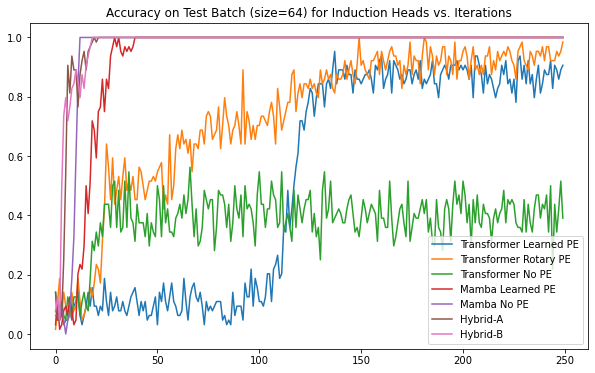

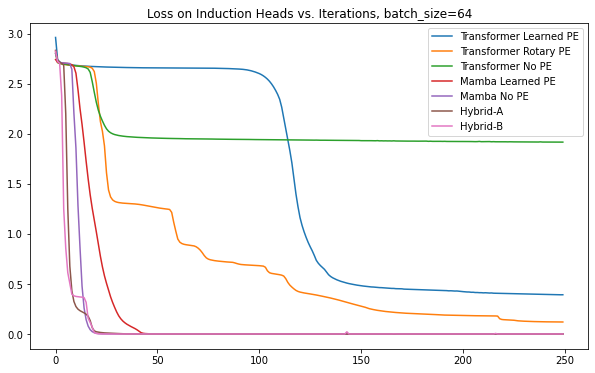

In [15]:
# generate loss plots per model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model_name, acc in test_single_batch_accuracies.items():
    plt.plot(acc, label=model_name)
plt.title(f"Accuracy on Test Batch (size={batch_size}) for Induction Heads vs. Iterations")
plt.legend()
plt.savefig(f"{run_name}_batch_acc.png")
plt.show()

plt.figure(figsize=(10, 6))
for model_name, loss in losses.items():
    plt.plot(loss, label=model_name)
plt.title(f"Loss on Induction Heads vs. Iterations, batch_size={batch_size}")
plt.legend()
plt.savefig(f"{run_name}_loss.png")
plt.show()

Generating example 0
Generating example 5000
Generating example 10000
Generating example 15000
Transformer Learned PE, Context length: 3, Test accuracy: 1.0
Transformer Rotary PE, Context length: 3, Test accuracy: 0.19424242424242424
Transformer No PE, Context length: 3, Test accuracy: 0.3977777777777778
Mamba Learned PE, Context length: 3, Test accuracy: 0.06651515151515151
Mamba No PE, Context length: 3, Test accuracy: 0.669949494949495
Hybrid-A, Context length: 3, Test accuracy: 0.8680808080808081
Hybrid-B, Context length: 3, Test accuracy: 0.4083838383838384
Generating example 0
Generating example 5000
Generating example 10000
Generating example 15000
Transformer Learned PE, Context length: 4, Test accuracy: 0.9046464646464647
Transformer Rotary PE, Context length: 4, Test accuracy: 0.3372727272727273
Transformer No PE, Context length: 4, Test accuracy: 0.444040404040404
Mamba Learned PE, Context length: 4, Test accuracy: 0.12863636363636363
Mamba No PE, Context length: 4, Test acc

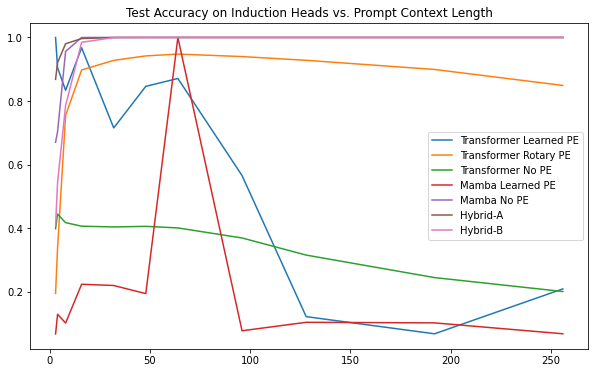

In [16]:
# generate test data with length 32
# test the model with the test data
num_examples = 20000
n_ctx_list = [3, 4, 8, 16, 32, 48, 64, 96, 128, 192, 256]
results = collections.defaultdict(list)

for n_ctx in n_ctx_list:
    dataset = InductionAR(num_examples, tokenizer, n_gram=1, n_ctx=n_ctx, seed=seed, train_split=0.01, tau=tau)
    train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

    for model_name, model in models.items():
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x,y = x.to(device), y.to(device)
                y_pred = model(x)[:,-1]
                y_pred = F.softmax(y_pred, dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                correct += (y_pred == y).sum().item()
                total += y.size(0)
            print(f"{model_name}, Context length: {n_ctx}, Test accuracy: {correct/total}")
            results[model_name].append(correct/total)

            
plt.figure(figsize=(10, 6))
for model_name, accuracies in results.items():
    plt.plot(n_ctx_list, accuracies, label=model_name)
plt.title("Test Accuracy on Induction Heads vs. Prompt Context Length")
plt.legend()
plt.savefig(f"{run_name}_test_acc.png")
plt.show()